In [17]:
# Cell 1 — imports & path setup
import sys, os
from pathlib import Path
import glob
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import optim

# add src/ to PYTHONPATH
PROJECT_ROOT = Path('..').resolve()
sys.path.append(str(PROJECT_ROOT / 'src'))

from utils       import load_image, load_mask, compute_vector_field
from engine      import AntEnv
from model       import AntModel


In [18]:
# Cell 2 — pick one example & env
images = sorted(glob.glob(str(PROJECT_ROOT / 'data/Fold1_jpg/images/*.jpg')))
masks  = sorted(glob.glob(str(PROJECT_ROOT / 'data/Fold1_jpg/masks/*.jpg')))

img = load_image(images[0])
mask = load_mask(masks[0])
vf  = compute_vector_field(mask)

env = AntEnv(image=img, mask=mask, vector_field=vf,
             kernel_size=(16,16), memory_len=100, max_steps=500)
(obs_patch, mem) = env.reset()
print(f"Start pos={env.pos}, patch={obs_patch.shape}, mem_len={len(mem)}")


Start pos=(222, 75), patch=(16, 16, 3), mem_len=0


In [19]:
# Cell 3 — instantiate model & do a dummy forward
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AntModel(in_channels=3, patch_size=(16,16),
                 emb_dim=128, n_actions=8, n_heads=4).to(device)
model.train()

# helper to convert one obs→ tensors
def pack_inputs(patch: np.ndarray, memory, device):
    # patch: H×W×3 → 1×3×H×W, normalized [0,1]
    pt = torch.from_numpy(patch.astype(np.float32)/255).permute(2,0,1).unsqueeze(0)
    pt = pt.to(device)
    # memory is list of (patch_np, action_unit_np)
    mem_t = []
    for p_np, a_np in memory:
        p_t = torch.from_numpy(p_np.astype(np.float32)/255).permute(2,0,1)
        a_t = torch.from_numpy(a_np.astype(np.float32))
        mem_t.append((p_t.to(device), a_t.to(device)))
    return pt, mem_t

# pack the very first obs & forward
pt, mem_t = pack_inputs(obs_patch, mem, device)
logits = model(pt, mem_t)           # 1×8
probs  = F.softmax(logits, dim=-1)
print("Logits:", logits.detach().cpu().numpy())
print("Probs sum to", probs.sum().item())


Logits: [[ 0.10205677  0.02510856 -0.01339936 -0.07664534  0.08063489 -0.04901147
   0.07274657  0.07390521]]
Probs sum to 1.0


In [20]:
# Cell 4 — optimizer & training params
optimizer = optim.Adam(model.parameters(), lr=1e-4)
n_episodes = 3
max_steps   = 100    # per episode
gamma       = 0.99   # reward discount


In [25]:
# Cell 5 — run episodes, collect episodic return
episode_returns = []

for ep in range(1, n_episodes+1):
    obs_patch, mem = env.reset()
    log_probs = []
    rewards   = []

    for t in range(max_steps):
        pt, mem_t = pack_inputs(obs_patch, mem, device)
        logits    = model(pt, mem_t)             # [1,8]
        dist      = torch.distributions.Categorical(logits=logits)
        action    = dist.sample().item()         # int 0–7
        lp        = dist.log_prob(torch.tensor(action, device=device))
        (obs2, mem2), reward, done, _ = env.step(action)

        log_probs.append(lp)
        rewards.append(reward)

        obs_patch, mem = obs2, mem2
        if done:
            break

    # compute discounted returns
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # policy gradient loss
    loss = []
    for lp, R in zip(log_probs, returns):
        loss.append(-lp * R)
    loss = torch.stack(loss).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    episode_returns.append(sum(rewards))
    if ep % 1 == 0:
        avg_ret = np.mean(episode_returns[-20:])
        print(f"Ep {ep:03d}  avg_return(last20) = {avg_ret:.3f}")



Ep 001  avg_return(last20) = 1.427
Ep 002  avg_return(last20) = -1.463
Ep 003  avg_return(last20) = -5.140


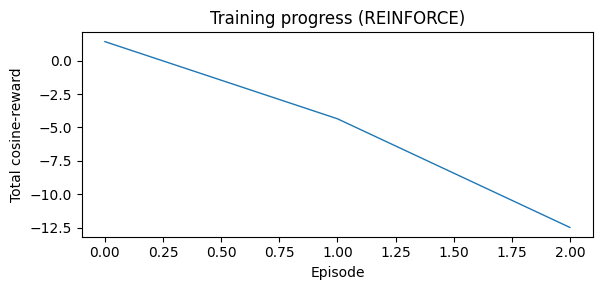

In [26]:
# Cell 6 — reward curve
plt.figure(figsize=(6,3))
plt.plot(episode_returns, linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Total cosine‐reward')
plt.title('Training progress (REINFORCE)')
plt.tight_layout()
plt.show()

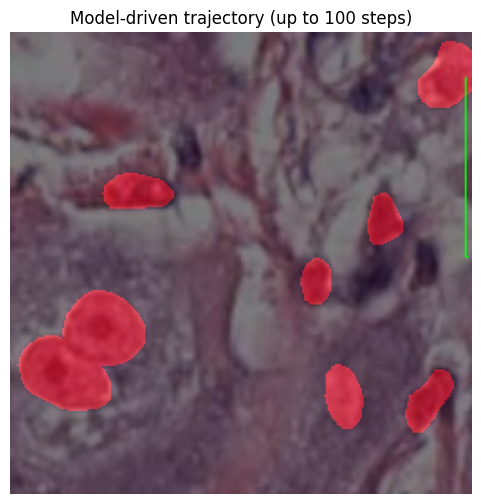

In [27]:
# Cell 7 — run the trained model for 100 steps and visualize its path

# Reset environment / clear previous trajectory
obs_patch, mem = env.reset()

# Roll out for up to 100 steps, using greedy policy
for step in range(100):
    # prepare inputs
    pt, mem_t = pack_inputs(obs_patch, mem, device)
    with torch.no_grad():
        logits = model(pt, mem_t)              # [1,8]
    action = int(logits.argmax(dim=-1).item())  # greedy action
    
    # step env
    (obs_patch, mem), reward, done, info = env.step(action)
    if done:
        print(f"Episode ended at step {step+1}")
        break

# render trajectory over image + mask
canvas = env.render(overlay_mask=True)
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.axis('off')
plt.title('Model‐driven trajectory (up to 100 steps)')
plt.show()

